In [5]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_metric(data_list, labels_list, dim=148):
    data = torch.tensor(np.array(data_list)).to(device)
    overall_data_mean = torch.mean(data, dim=0)
    bcss = torch.zeros(dim, device=device)
    wcss = torch.zeros(dim, device=device)

    unique_labels = list(set(labels_list))
    
    #unique_labels = [label for label in unique_labels if not label in ['label_inpaint black square']]
    
    label_dict = {label: index for index, label in enumerate(unique_labels)}
    labels_list_number = torch.tensor([label_dict[label] for label in labels_list]).to(device)

    for group_label in set(labels_list_number):
        
        
        group_indices = torch.nonzero(labels_list_number == group_label, as_tuple=False).squeeze()
        group_data = data[group_indices]
        
        group_mean = torch.mean(group_data, dim=0)

        current_bcss = len(group_indices) * torch.sum((group_mean - overall_data_mean) ** 2, dim=1)
        current_wcss = torch.sum((group_data - group_mean) ** 2, dim=(0,2))

        bcss += current_bcss
        wcss += current_wcss

    ratios = bcss / wcss
    assert ratios.shape[0] == dim
    return ratios.cpu()

In [3]:
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/latents_2/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    z = iter(h5file.values())
    first_element = next(z)
    print(first_element.keys())

<KeysViewHDF5 ['label_colorization', 'label_inpaint black square', 'label_inpaint double random', 'label_inpaint single random', 'label_lowlight enhance', 'label_neutral copy', 'label_segmentation', 'label_uncolor']>


In [9]:
alpha_labels = ['label_colorization', 'label_inpaint double random', 'label_inpaint single random', 'label_lowlight enhance', 'label_segmentation', 'label_uncolor']

In [10]:
# Open the file in read mode
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/normalized_neural_activations_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    
    encoder_layers = first_element['label_segmentation']['encoder_latent'].shape[0]
    decoder_layers = first_element['label_segmentation']['decoder_latent'].shape[0]
    print(encoder_layers, decoder_layers)
    for i in tqdm(range(encoder_layers)):
        data_list = []
        labels_list = []
        for pass_name, pass_group in h5file.items():
            if pass_name.startswith('pass_'):
                label_level = []    
                for label_name, label_group in pass_group.items():
                    if label_name.startswith('label_') and 'encoder_latent' in label_group and label_name in alpha_labels:
                        label_level.append(label_group['encoder_latent'][i][0].copy())
                        labels_list.append(label_name)
                    
                data_list.extend(label_level)

        # Compute metric and append to holder
        regular = compute_metric(data_list, labels_list)
        encoder_metric_holder.append(regular)

24 8


100%|██████████| 24/24 [05:53<00:00, 14.73s/it]


In [12]:
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/normalized_neural_activations_1/dataset.hdf5", 'r') as h5file: 
    decoder_metric_holder = []
    for i in tqdm(range(decoder_layers)):
        data_list = []
        labels_list = []
        for pass_name, pass_group in h5file.items():
            if pass_name.startswith('pass_'):
                label_level = []    
                for label_name, label_group in pass_group.items():
                    if label_name.startswith('label_') and 'decoder_latent' in label_group and label_name in alpha_labels:
                        label_level.append(label_group['decoder_latent'][i][0].copy())
                        labels_list.append(label_name)
                    
                
                data_list.extend(label_level)
        # Compute metric and append to holder
        regular = compute_metric(data_list, labels_list, dim=197)
        decoder_metric_holder.append(regular)

100%|██████████| 8/8 [00:38<00:00,  4.84s/it]


In [13]:
encoder_matrix = torch.vstack(encoder_metric_holder)
decoder_matrix = torch.vstack(decoder_metric_holder)
padding_width = decoder_matrix.shape[1] - encoder_matrix.shape[1]
padded_encoder_matrix = torch.nn.functional.pad(encoder_matrix, (0, padding_width))
stacked_matrix = torch.vstack([padded_encoder_matrix, decoder_matrix])

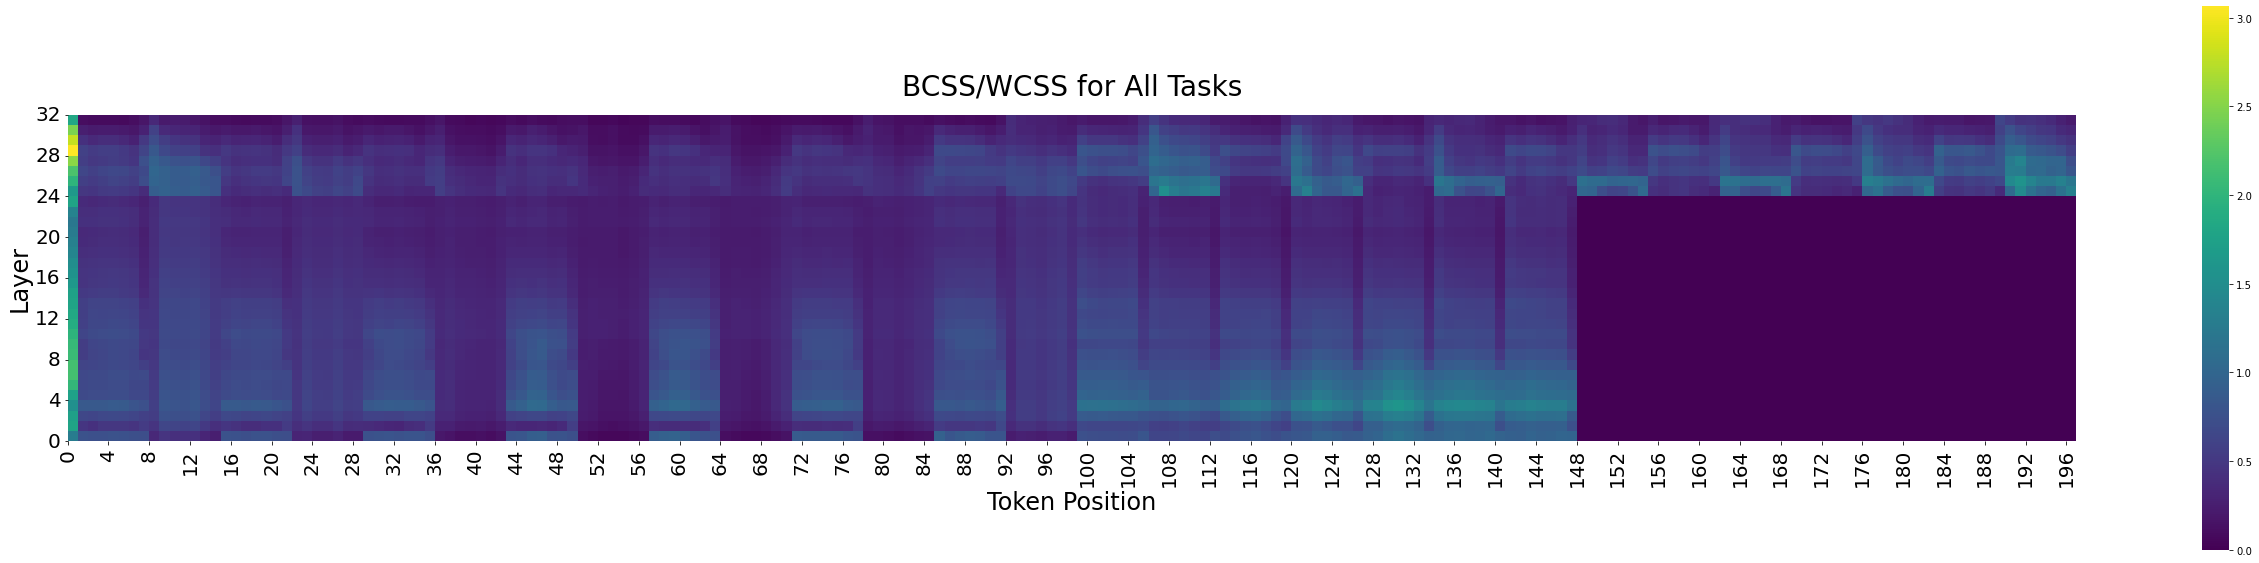

In [14]:
def plot_widemap(matrix_data, title):

    # Creating the heatmap
    plt.figure(figsize=(45, 10))  # Adjust the figure size as needed
    sns.heatmap(matrix_data, cmap='viridis', square=True)

    # Setting the labels for axes
    plt.xlabel('Token Position', fontsize=24)
    plt.ylabel('Layer', fontsize=24)

    # Inverting the y-axis to have the first layer at the bottom
    plt.gca().invert_yaxis()

    # Adding title
    plt.title(title, fontsize=28, pad=20)
    plt.yticks(np.arange(0, matrix_data.shape[0]+1, 4), np.arange(0, matrix_data.shape[0]+1, 4), fontsize=20)
    plt.xticks(np.arange(0, matrix_data.shape[1]+1, 4), np.arange(0, matrix_data.shape[1]+1, 4), fontsize=20)

    plt.show()

plot_widemap(stacked_matrix, 'BCSS/WCSS for All Tasks')
#plot_widemap(stacked_matrix_alpha, 'BCSS/WCSS for Constrained Tasks (alpha)')

In [15]:
import torch

def unpatchify_adapted(x):
    """
    x: (N, 196)
    imgs: (N, 14, 14)
    """
    h = w = 14  # Image dimensions
    imgs = x.reshape(x.shape[0], h, w)
    return imgs

def create_special_image(pixels):
    # Initialize an empty 14x14 array
    image = torch.zeros(14, 14)

    # Fill the top half (7 rows) with the first 98 pixels
    top_half = torch.tensor(pixels[:98]).reshape(7, 14)
    image[:7, :] = top_half

    # Fill the bottom-left quadrant with the next 49 pixels
    bottom_left_quadrant = torch.tensor(pixels[98:]).reshape(7, 7)
    image[7:, :7] = bottom_left_quadrant

    return image

def batch_process(stacked_matrix):
    # Split the matrix into two parts
    special_images = stacked_matrix[:24, :147]  # First 24 images, first 147 pixels
    full_images = stacked_matrix[24:,]       # Last 8 images, excluding the first pixel

    # Process the special images
    special_processed = torch.stack([create_special_image(img) for img in special_images])

    # Process the full images
    full_processed = unpatchify_adapted(full_images)

    # Combine the results
    combined = torch.cat((special_processed, full_processed), dim=0)
    return combined


In [17]:
batched_images = batch_process(stacked_matrix[:, 1:])

/tmp/ipykernel_3055549/182247731.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_half = torch.tensor(pixels[:98]).reshape(7, 14)
/tmp/ipykernel_3055549/182247731.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bottom_left_quadrant = torch.tensor(pixels[98:]).reshape(7, 7)


/tmp/ipykernel_3055549/519191466.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to account for the added colorbar axis


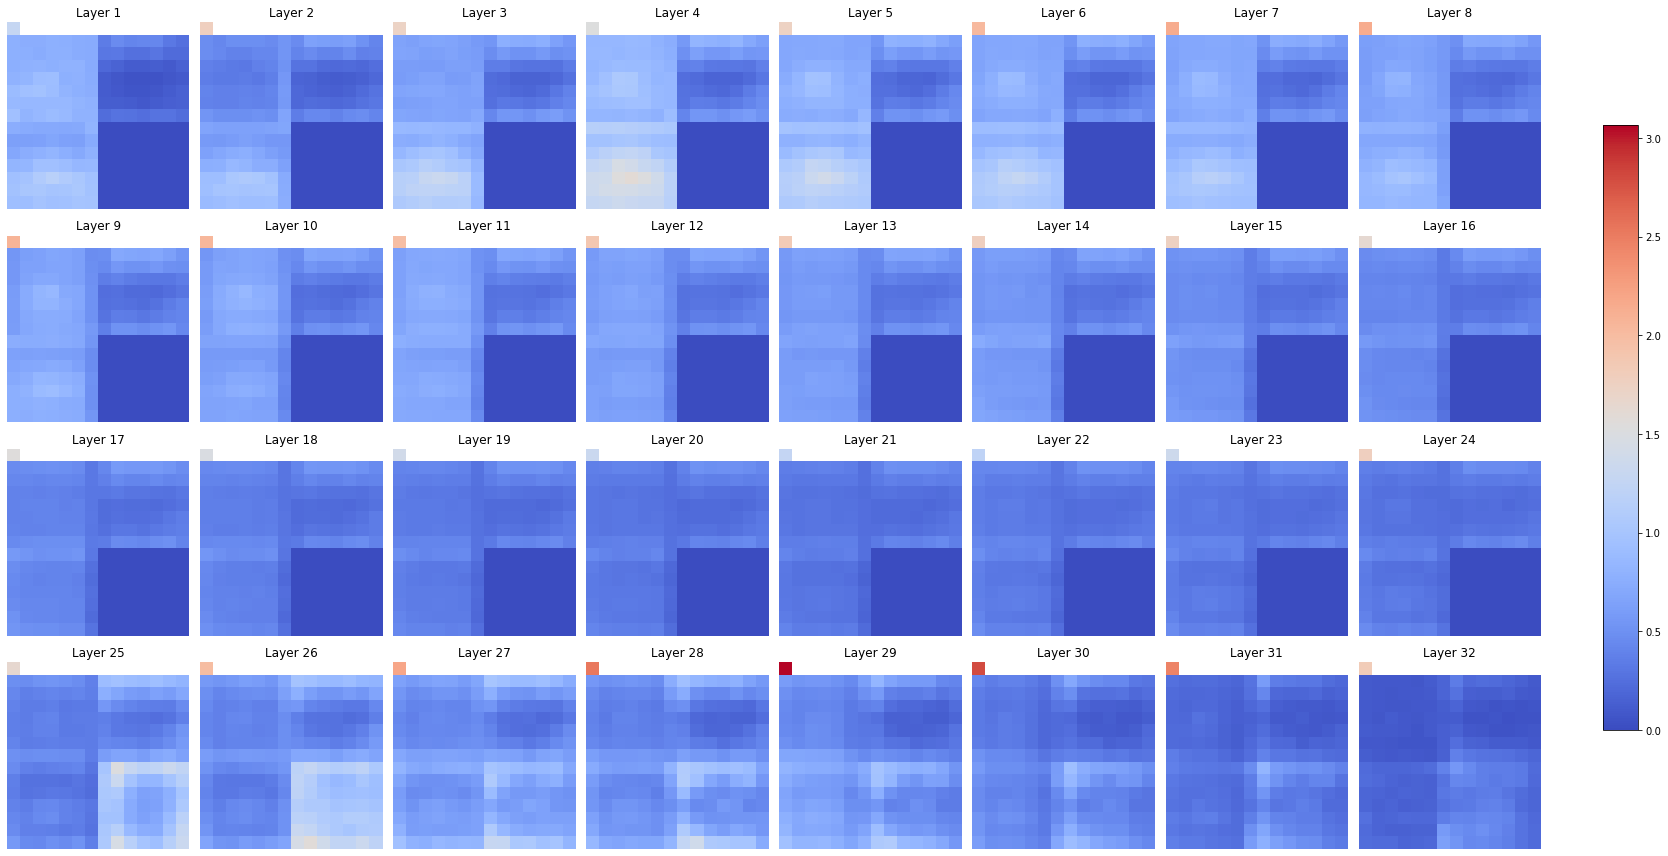

In [18]:
# Find global min and max for consistent color range across all heatmaps
global_min = stacked_matrix.min()
global_max = stacked_matrix.max()

batched_alpha_pixel = stacked_matrix[:, :1].squeeze()

# Set up the matplotlib figure with 32 subplots for images and 32 for alpha_pixel indicators
fig, axes = plt.subplots(4, 8, figsize=(24, 12))  # Adjust the figure size as needed
fig.patch.set_facecolor('white')  # Set the background to white

# Generate heatmaps for each image with an additional alpha pixel
for i, ax in enumerate(axes.flatten()):
    # Create a 15x14 matrix with NaNs and place the alpha_pixel at the top left
    extended_matrix = np.full((15, 14), np.nan)
    extended_matrix[0, 0] = batched_alpha_pixel[i]  # Set the top left to the alpha_pixel value
    extended_matrix[1:, :] = batched_images[i]      # Place the original image below

    # Plot the extended heatmap
    sns.heatmap(extended_matrix, cmap='coolwarm', ax=ax, cbar=False, square=False,
                vmin=global_min, vmax=global_max, mask=np.isnan(extended_matrix))
    ax.set_title(f'Layer {i+1}')
    ax.set_xticks([])
    ax.set_yticks([])

# Create an axis for the color bar on the right side
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height
norm = plt.Normalize(global_min, global_max)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

# Add the main title

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to account for the added colorbar axis
plt.show()

In [97]:
import os
import imageio

global_min = stacked_matrix.min().item()
global_max = stacked_matrix.max().item()

frames_dir = 'gif/frames'
os.makedirs(frames_dir, exist_ok=True)

# Filename for the gif
gif_filename = 'gif/heatmap_animation.gif'

# Generate and save each frame
filenames = []
for i in range(len(batched_images)):
    # Create a 15x14 matrix with NaNs and place the alpha_pixel at the top left
    extended_matrix = np.full((15, 14), np.nan)
    extended_matrix[0, 0] = batched_alpha_pixel[i].item()  # Set the top left to the alpha_pixel value
    extended_matrix[1:, :] = batched_images[i].numpy()     # Place the original image below

    # Plot the extended heatmap
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(extended_matrix, cmap='coolwarm', ax=ax, cbar=False, square=False,
                vmin=global_min, vmax=global_max, mask=np.isnan(extended_matrix))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Layer {i+1}')

    # Save the frame
    frame_filename = f'{frames_dir}/frame_{i:04d}.png'
    plt.savefig(frame_filename)
    plt.close()
    filenames.append(frame_filename)

# Compile the frames into a GIF
with imageio.get_writer(gif_filename, mode='I', duration=0.5, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# The path to the GIF file that has been created
gif_path = gif_filename

/tmp/ipykernel_2454058/1778093125.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


NameError: name 'shutil' is not defined

In [8]:
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/normalized_neural_activations_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    print(first_element.keys())

<KeysViewHDF5 ['label_colorization', 'label_inpaint double random', 'label_inpaint single random', 'label_lowlight enhance', 'label_segmentation', 'label_uncolor']>


In [3]:
first_element

<Closed HDF5 group>

In [19]:
beta_labels = ['label_colorization', 'label_inpaint double random', 'label_inpaint single random', 'label_lowlight enhance', 'label_segmentation', 'label_uncolor']

holder = {}

with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/normalized_neural_activations_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    
    encoder_layers = first_element['label_segmentation']['encoder_latent'].shape[0]
    decoder_layers = first_element['label_segmentation']['decoder_latent'].shape[0]
    print(encoder_layers, decoder_layers)
    
    for label_name in beta_labels:
        if label_name.startswith('label_'):
            label_decoder_level = [] 
            label_encoder_level = [] 

            for pass_name, pass_group in tqdm(h5file.items()):
                if pass_name.startswith('pass_'):
                    
                    label_encoder_level.append(pass_group[label_name]['encoder_latent'][:,0])
                    label_decoder_level.append(pass_group[label_name]['decoder_latent'][:,0])

            encoder_tensor = torch.tensor(np.array(label_encoder_level))
            decoder_tensor = torch.tensor(np.array(label_decoder_level))
            print(encoder_tensor.shape)
            encoder_mean = encoder_tensor.mean(dim=0)
            decoder_mean = decoder_tensor.mean(dim=0)

            print(encoder_tensor.shape, encoder_mean.shape)

            curr = {
                "mean": [{"encoder": encoder_mean, "decoder": decoder_mean}]
            }

            holder[label_name] = curr

24 8


100%|██████████| 170/170 [00:24<00:00,  7.00it/s]


torch.Size([170, 24, 148, 1024])
torch.Size([170, 24, 148, 1024]) torch.Size([24, 148, 1024])


100%|██████████| 170/170 [00:24<00:00,  6.89it/s]


torch.Size([170, 24, 148, 1024])
torch.Size([170, 24, 148, 1024]) torch.Size([24, 148, 1024])


100%|██████████| 170/170 [00:24<00:00,  6.94it/s]


torch.Size([170, 24, 148, 1024])
torch.Size([170, 24, 148, 1024]) torch.Size([24, 148, 1024])


100%|██████████| 170/170 [00:23<00:00,  7.10it/s]


torch.Size([170, 24, 148, 1024])
torch.Size([170, 24, 148, 1024]) torch.Size([24, 148, 1024])


100%|██████████| 170/170 [00:23<00:00,  7.30it/s]


torch.Size([170, 24, 148, 1024])
torch.Size([170, 24, 148, 1024]) torch.Size([24, 148, 1024])


100%|██████████| 170/170 [00:23<00:00,  7.11it/s]


torch.Size([170, 24, 148, 1024])
torch.Size([170, 24, 148, 1024]) torch.Size([24, 148, 1024])


In [20]:
holder.pop('label_neutral copy', None)


{'mean': [{'encoder': tensor(nan, dtype=torch.float64),
   'decoder': tensor(nan, dtype=torch.float64)}]}

In [26]:
[print(holder[k]["mean"][0]["encoder"].shape) for k in holder.keys()]


torch.Size([24, 148, 1024])
torch.Size([24, 148, 1024])
torch.Size([24, 148, 1024])
torch.Size([24, 148, 1024])
torch.Size([24, 148, 1024])
torch.Size([24, 148, 1024])


[None, None, None, None, None, None]

In [27]:
import pickle 
with open("/home/ahojel/visual_prompting_vid/vectors/mean_norm_activations.pkl", "wb") as file:
    pickle.dump(holder, file)

Encoder shape: torch.Size([24, 148, 1024])


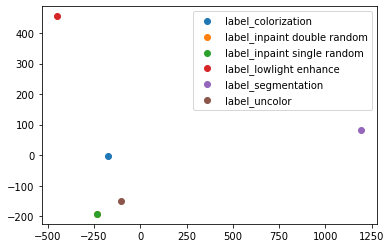

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the shape of the encoder
encoder_shape = holder["label_colorization"]["mean"][0]["encoder"].shape
print(f'Encoder shape: {encoder_shape}')

# Reshape the encoder data and create a dataset
dataset = np.array([holder[k]["mean"][0]["encoder"].reshape(-1) for k in holder.keys()])

# Perform PCA on the dataset
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataset)

# Plot the PCA result
for i, label in enumerate(holder.keys()):
    #if label == "label_inpaint double random":
    plt.scatter(pca_result[i, 0], pca_result[i, 1], label=label)

plt.legend()
plt.show()


Encoder shape: torch.Size([8, 197, 512])


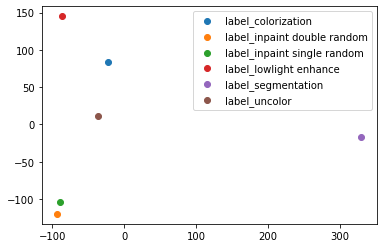

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the shape of the encoder
encoder_shape = holder["label_colorization"]["mean"][0]["decoder"].shape
print(f'Encoder shape: {encoder_shape}')

# Reshape the encoder data and create a dataset
dataset = np.array([holder[k]["mean"][0]["decoder"].reshape(-1) for k in holder.keys()])

# Perform PCA on the dataset
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataset)

# Plot the PCA result
for i, label in enumerate(holder.keys()):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], label=label)

plt.legend()
plt.show()


In [4]:
len(labels_list), len(encoder_data_list), len(decoder_data_list)

(1190, 1190, 1190)

In [5]:
decoder_data_list[0].shape

(8, 197, 512)

In [45]:
stacked_decoder_data = [ele.reshape(4096) for ele in decoder_data_list]
stacked_encoder_data = [ele.reshape(24576) for ele in encoder_data_list]

In [8]:
import pickle
import torch
import numpy as np

holder = {}

for i in set(labels_list):
    print(i)
    keep_indices = np.array(labels_list) == i
    kept_decoder = torch.tensor(decoder_data_list)[keep_indices]
    kept_encoder = torch.tensor(encoder_data_list)[keep_indices]

    encoder_mean = kept_encoder.mean(dim=0)
    decoder_mean = kept_decoder.mean(dim=0)

    
    curr = {
            "mean": [{"encoder": encoder_mean, "decoder": decoder_mean}]
        }

    holder[i] = curr


In [57]:
import pickle
import torch
import numpy as np

holder = {}

for i in set(labels_list):
    keep_indices = np.array(labels_list) == i
    kept_decoder = torch.tensor(decoder_data_list)[keep_indices]
    kept_encoder = torch.tensor(encoder_data_list)[keep_indices]

    encoder_mean = kept_encoder.mean(dim=0)
    decoder_mean = kept_decoder.mean(dim=0)

    # Calculate distances from the mean
    distances_encoder = torch.norm(kept_encoder - encoder_mean, dim=2)
    distances_decoder = torch.norm(kept_decoder - decoder_mean, dim=2)

    closest_full_encoder_idx = torch.argmin(distances_encoder.norm(dim=1))
    closest_full_decoder_idx = torch.argmin(distances_decoder.norm(dim=1))
    closest_full_encoder = kept_encoder[closest_full_encoder_idx]
    closest_full_decoder = kept_decoder[closest_full_decoder_idx]

    closest_piecewise_encoder = torch.zeros_like(kept_encoder[0])
    for layer in range(kept_encoder.shape[1]):
        # Calculate the mean for the current layer
        layer_mean = kept_encoder[:, layer, :].mean(dim=0)

        # Calculate distances from the layer mean
        distances = torch.norm(kept_encoder[:, layer, :] - layer_mean, dim=1)

        # Find the index of the minimum distance
        closest_idx = torch.argmin(distances)

        # Store the closest vector for this layer
        closest_piecewise_encoder[layer] = kept_encoder[closest_idx, layer]

    closest_piecewise_decoder = torch.zeros_like(kept_decoder[0])
    for layer in range(kept_decoder.shape[1]):

        # Calculate the mean for the current layer
        layer_mean = kept_decoder[:, layer, :].mean(dim=0)

        # Calculate distances from the layer mean
        distances = torch.norm(kept_decoder[:, layer, :] - layer_mean, dim=1)

        # Find the index of the minimum distance
        closest_idx = torch.argmin(distances)

        # Store the closest vector for this layer
        closest_piecewise_decoder[layer] = kept_decoder[closest_idx, layer]

    curr = {
            "mean": [{"encoder": encoder_mean, "decoder": decoder_mean}],
            "median": [{"encoder": kept_encoder.median(dim=0), "decoder": kept_decoder.median(dim=0)}],
            "closest_to_mean": [{"encoder": closest_full_encoder, "decoder": closest_full_decoder}],
            "piecewise_closest_to_mean": [{"encoder": closest_piecewise_encoder, "decoder": closest_piecewise_decoder}]
        }

    holder[i] = curr


In [30]:
import pickle 
with open("vectors/master_1.pkl", "rb") as file:
    data = pickle.load(file)
        

In [34]:
data["label_colorization"]["mean"][0]["encoder"].shape

torch.Size([24, 1024])

In [60]:
file_path = "vectors/master_1.pkl"
with open(file_path, "wb") as file:
    pickle.dump(holder, file)

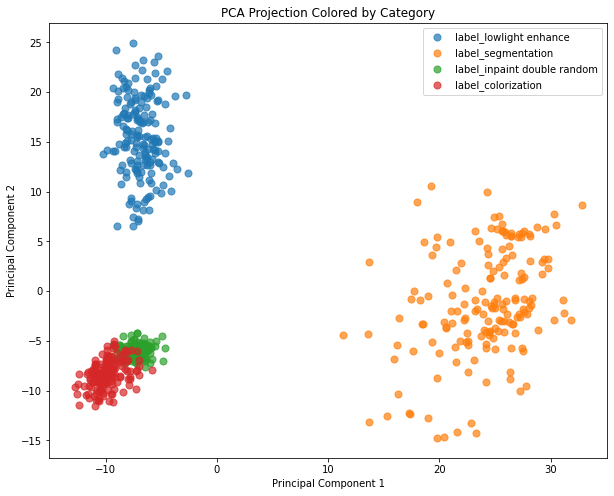

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch  # Ensure torch is imported

all_features = torch.tensor(np.array(decoder_layer_5))

# Convert the PyTorch tensor to a NumPy array
all_features_np = all_features.numpy()

# Standardize the features
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features_np)

# Apply PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(all_features_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 8))

categories = list(set(labels_list))
for category in categories:
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category  # Ensure labels_list is in a compatible format
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], s=50, alpha=0.7, label=category)  # Adjusted marker size

# Add plot title, labels, and legend
plt.title('PCA Projection Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

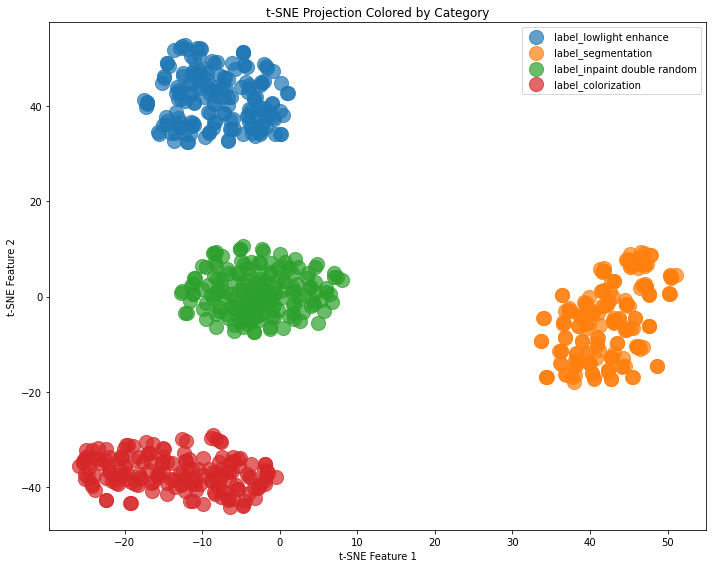

In [56]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 8))
categories = list(set(labels_list))
for category in categories:
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 200, alpha=0.7, label=category)

# Add plot title, labels, and legend
plt.title('t-SNE Projection Colored by Category')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()  # Places the legend to the right of the plot

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()